In [1]:
%load_ext autoreload
%autoreload 2

In [115]:
# LOG_PATH="/Users/law/repos/ma/disco/benchmark-runs/runs_latency/tumbling_1000_max"
LOG_PATH="/Users/law/repos/ma/disco/benchmark-runs/runs_latency/test"

In [138]:
import os
import re

RUN_RE = re.compile(r"Running (\d+) child.*, (\d+) stream.*")
LOG_DIR_RE = re.compile(r"Latencies in dir: (.*)")
QUARTER_RE = re.compile(r"Running with quarter events/s: (\d+)")
HALF_RE = re.compile(r"Running with half events/s: (\d+)")
THREE_QUARTER_RE = re.compile(r"Running with three quarter events/s: (\d+)")
FULL_RE = re.compile(r"Running with full events/s: (\d+)")
LATENCY_RE = re.compile(r"Latency for window.* windowStartTimestamp=(\d+), windowEndTimestamp=(\d+).* --> (\d+)")

def parse_latencies(root_file):
    latencies = {}
    current_latencies = []
    current_percentage = "0"
    
    with open(root_file) as f:
        for line in f:
            quarter_match = QUARTER_RE.match(line)
            if quarter_match is not None:
                quarter_throughput = int(quarter_match.group(1))
                current_percentage = "25"
                sustainable_throughputs[current_percentage] = quarter_throughput
                continue

            half_match = HALF_RE.match(line)
            if half_match is not None:
                latencies[current_percentage] = current_latencies.copy()
                current_latencies = []

                half_throughput = int(half_match.group(1))
                current_percentage = "50"
                sustainable_throughputs[current_percentage] = half_throughput
                continue

            three_quarter_match = THREE_QUARTER_RE.match(line)
            if three_quarter_match is not None:
                latencies[current_percentage] = current_latencies.copy()
                current_latencies = []

                three_quarter_throughput = int(three_quarter_match.group(1))
                current_percentage = "75"
                sustainable_throughputs[current_percentage] = three_quarter_throughput
                continue

            full_match = FULL_RE.match(line)
            if full_match is not None:
                latencies[current_percentage] = current_latencies.copy()
                current_latencies = []

                full_throughput = int(full_match.group(1))
                current_percentage = "100"
                sustainable_throughputs[current_percentage] = full_throughput
                continue

            latency_match = LATENCY_RE.match(line)
            if latency_match is not None:
                window_start = int(latency_match.group(1))
                window_end = int(latency_match.group(2))
                latency = int(latency_match.group(3))
                current_latencies.append((window_start, window_end, latency))
                continue
                    
    latencies[current_percentage] = current_latencies
    return latencies


def parse_log_file(log_file):
    all_latencies = {}
    current_run = None
    
    with open(log_file) as f:
        for line in f:
            run_match = RUN_RE.match(line)
            if run_match is not None:
                assert current_run is None, f"Did not find logs for {current_run}"
                current_run = (int(run_match.group(1)), int(run_match.group(2)))
                continue
                
            log_dir_match = LOG_DIR_RE.match(line)
            if log_dir_match is not None:
                assert current_run is not None
                absolute_log_dir = log_dir_match.group(1)
                log_dir = os.path.join(LOG_PATH, os.path.basename(absolute_log_dir), "root.log")
                print(f" '--> Parsing {log_dir}")
                latencies = parse_latencies(log_dir)
                all_latencies[current_run] = latencies
                current_run = None
                continue
                
    return all_latencies
                

ALL_LATENCIES = {}
for log_file in sorted(os.listdir(LOG_PATH)):
    if log_file.endswith(".log"):
        print(f"Parsing {log_file}")
        abs_log_file = os.path.join(LOG_PATH, log_file)
        latencies = parse_log_file(abs_log_file)
        ALL_LATENCIES = {**ALL_LATENCIES, **latencies}
nl = '\n'
print(f"\nALL_LATENCIES:\n{ALL_LATENCIES}")
        

Parsing test_latency.log
 '--> Parsing /Users/law/repos/ma/disco/benchmark-runs/runs_latency/test/2019-09-02-1741_3-nodes_968000-events_120-seconds/root.log

ALL_LATENCIES:
{(1, 1): {'0': [(1000, 2000, 1397), (2000, 3000, 1245), (3000, 4000, 1172), (4000, 5000, 936), (5000, 6000, 696), (6000, 7000, 422), (7000, 8000, 139), (8000, 9000, 110), (9000, 10000, 186), (10000, 11000, 110), (11000, 12000, 109), (12000, 13000, 104), (13000, 14000, 106), (14000, 15000, 103), (15000, 16000, 111), (16000, 17000, 110), (17000, 18000, 107), (18000, 19000, 103), (19000, 20000, 105), (20000, 21000, 111), (21000, 22000, 107), (22000, 23000, 129), (23000, 24000, 126), (24000, 25000, 120), (25000, 26000, 111), (26000, 27000, 113), (27000, 28000, 111), (28000, 29000, 110), (29000, 30000, 108), (30000, 31000, 105), (31000, 32000, 136), (32000, 33000, 121), (33000, 34000, 108), (34000, 35000, 111), (35000, 36000, 185), (36000, 37000, 110), (37000, 38000, 107), (38000, 39000, 103), (39000, 40000, 106), (40000

In [99]:
WINDOW_START = 30000
WINDOW_END   = 90000

LATENCIES = {}
for run, all_latencies in ALL_LATENCIES.items():
    filtered_latencies = []
    for percentage, latencies in all_latencies.items():
        percentage_latencies = []
        for latency in latencies:
            if latency[0] >= WINDOW_START and latency[1] <= WINDOW_END:
                percentage_latencies.append(latency[2])

        if len(percentage_latencies) < 45:
            print(f"Missing latencies for {run} {percentage}%...")
            filtered_latencies.append([])
        else:
            filtered_latencies.append(percentage_latencies)
        
    LATENCIES[run] = filtered_latencies
        
print(LATENCIES)

{}


# Plots

In [82]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True, 'pgf.rcfonts' : False})

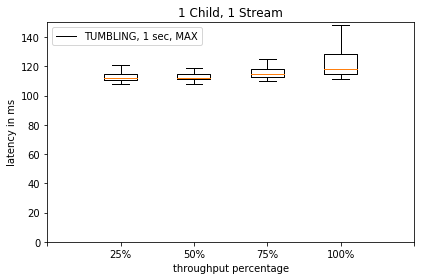

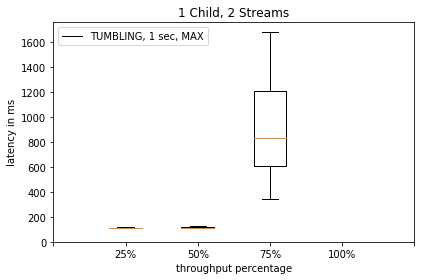

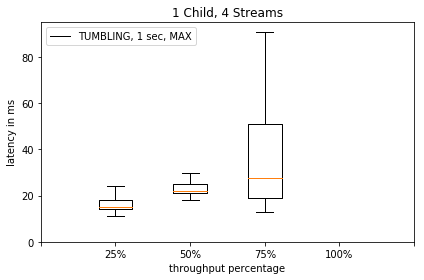

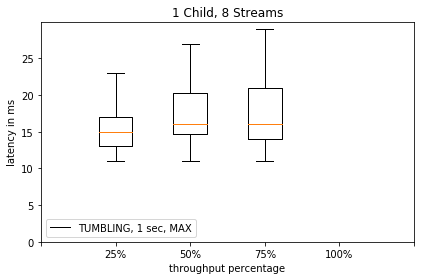

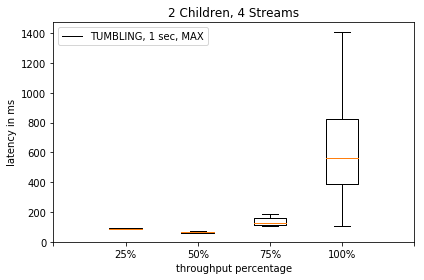

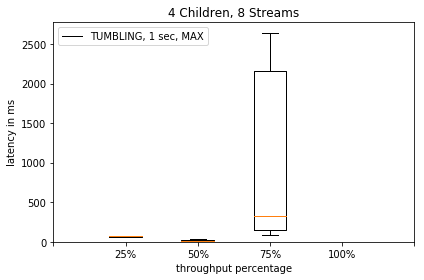

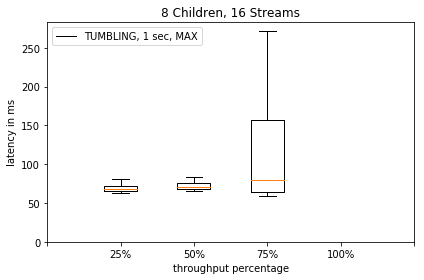

In [91]:
def plot_latencies(latencies, titel):
    plt.boxplot(latencies, showfliers=False) #, whis=[0, 90])
    plt.title(titel)
    plt.ylabel("latency in ms")
    plt.xlabel("throughput percentage")
    plt.legend(["TUMBLING, 1 sec, MAX"])
    plt.ylim(ymin=0)
    plt.xticks(range(6), ["", "25%", "50%", "75%", "100%"])
    plt.show()

plot_latencies(LATENCIES[(1,  1)], "1 Child, 1 Stream")
plot_latencies(LATENCIES[(1,  2)], "1 Child, 2 Streams")
plot_latencies(LATENCIES[(1,  4)], "1 Child, 4 Streams")
plot_latencies(LATENCIES[(1,  8)], "1 Child, 8 Streams")
plot_latencies(LATENCIES[(2,  4)], "2 Children, 4 Streams")
plot_latencies(LATENCIES[(4,  8)], "4 Children, 8 Streams")
plot_latencies(LATENCIES[(8, 16)], "8 Children, 16 Streams")

# if save_fig:
#     plt.savefig(f"load_{out_file_name}.svg")
#     plt.savefig(f"load_{out_file_name}.pgf")
#     plt.savefig(f"load_{out_file_name}.png")
# plt.show()